In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from data_generators.basic_generator import BasicDataGenerator
from data_generators.standard_generator import StandardDataGenerator
from environments.Joint100Env import JointEnvironment
from learners.joint.JointTS import JointTS
from learners.pricing.ucb import UCB

In [14]:
data_gen = BasicDataGenerator(filename='src/basic003.json')
prices = data_gen.get_prices()
bids = data_gen.get_bids()
margins = data_gen.get_margins()
conv_rates = data_gen.get_conversion_rates(mode='aggregate')
n_clicks = data_gen.get_daily_clicks(mode='aggregate')
costs_per_click = data_gen.get_costs_per_click(mode='aggregate')
aggr_tau = data_gen.get_future_purchases(mode='aggregate')

print(15*'-','DATA', '-'*15)
print(f'{prices=}')
print(f'{bids=}')
print(f'{margins=}')
print(f'{conv_rates=}')
print(f'{costs_per_click=}')
print(f'{n_clicks=}')
print(f'{aggr_tau=}')

arms = np.array(np.meshgrid(margins, bids)).T.reshape(len(margins)*len(bids), 2)
n_arms = len(arms)
env_params = {
        'mode': 'aggregate',
        'src': 'src/basic003.json',
}

--------------- DATA ---------------
prices=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
bids=[0.3, 0.35, 0.4, 0.5, 0.6, 0.75, 0.9, 1.0, 1.25, 1.5]
margins=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
conv_rates=array([0.204, 0.211, 0.205, 0.189, 0.176, 0.152, 0.128, 0.113, 0.097,
       0.09 ])
costs_per_click=array([0.294, 0.342, 0.389, 0.483, 0.576, 0.713, 0.847, 0.935, 1.151,
       1.361])
n_clicks=array([115.248, 124.161, 131.72 , 143.8  , 152.973, 163.133, 170.442,
       174.226, 181.125, 185.61 ])
aggr_tau=array([2.85 , 2.485, 2.12 , 1.755, 1.39 , 1.025, 0.84 , 0.69 , 0.65 ,
       0.65 ])


In [15]:
print('\n', 15 * '-', 'SIMULATION PARAMS', '-' * 15)
T = 700
n_experiments = 20
print(f'Time horizon: {T} days')
print(f'Num. experiments: {n_experiments}')


 --------------- SIMULATION PARAMS ---------------
Time horizon: 700 days
Num. experiments: 20


In [16]:
margins_rep = np.repeat(margins, len(margins))
conv_rates_rep = np.repeat(conv_rates, len(margins))
n_clicks_tile = np.tile(n_clicks, len(bids))
costs_per_click_tile = np.tile(costs_per_click, len(bids))
tau_rep = np.repeat(aggr_tau, len(margins))

In [17]:
opt_arm = np.argmax((margins_rep * conv_rates_rep * (1 + tau_rep) - costs_per_click_tile) * n_clicks_tile)
opt_arm
print(f'N_ARMS: {n_arms}')
print(f'Arms:\n {arms}')
print(f'Optimal arm: {str(opt_arm)}')

N_ARMS: 100
Arms:
 [[ 3.    0.3 ]
 [ 3.    0.35]
 [ 3.    0.4 ]
 [ 3.    0.5 ]
 [ 3.    0.6 ]
 [ 3.    0.75]
 [ 3.    0.9 ]
 [ 3.    1.  ]
 [ 3.    1.25]
 [ 3.    1.5 ]
 [ 4.    0.3 ]
 [ 4.    0.35]
 [ 4.    0.4 ]
 [ 4.    0.5 ]
 [ 4.    0.6 ]
 [ 4.    0.75]
 [ 4.    0.9 ]
 [ 4.    1.  ]
 [ 4.    1.25]
 [ 4.    1.5 ]
 [ 5.    0.3 ]
 [ 5.    0.35]
 [ 5.    0.4 ]
 [ 5.    0.5 ]
 [ 5.    0.6 ]
 [ 5.    0.75]
 [ 5.    0.9 ]
 [ 5.    1.  ]
 [ 5.    1.25]
 [ 5.    1.5 ]
 [ 6.    0.3 ]
 [ 6.    0.35]
 [ 6.    0.4 ]
 [ 6.    0.5 ]
 [ 6.    0.6 ]
 [ 6.    0.75]
 [ 6.    0.9 ]
 [ 6.    1.  ]
 [ 6.    1.25]
 [ 6.    1.5 ]
 [ 7.    0.3 ]
 [ 7.    0.35]
 [ 7.    0.4 ]
 [ 7.    0.5 ]
 [ 7.    0.6 ]
 [ 7.    0.75]
 [ 7.    0.9 ]
 [ 7.    1.  ]
 [ 7.    1.25]
 [ 7.    1.5 ]
 [ 8.    0.3 ]
 [ 8.    0.35]
 [ 8.    0.4 ]
 [ 8.    0.5 ]
 [ 8.    0.6 ]
 [ 8.    0.75]
 [ 8.    0.9 ]
 [ 8.    1.  ]
 [ 8.    1.25]
 [ 8.    1.5 ]
 [ 9.    0.3 ]
 [ 9.    0.35]
 [ 9.    0.4 ]
 [ 9.    0.5 ]
 [ 9.    0.6 ]
 [ 9. 

In [18]:
learners_to_test = [JointTS]
rewards_per_experiment = []

print(f'N_ROUNDS: {T}')
print(f'N_EXPERIMENTS: {n_experiments}')

N_ROUNDS: 700
N_EXPERIMENTS: 20


In [19]:
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    print(f'running exp#{e}...')
    test_instances = []
    learner = JointTS(arm_values = arms)
    env = JointEnvironment(**env_params)
    opt = env.get_opt()
    opt_arm = env.get_opt_arm()
    print(f'Optimal value: {opt}, at optimal arm: {opt_arm}')
    for t in range(T):
        learner.next_day()
        month_purchases = env.get_next_purchases_at_day(t, keep=False)
        if month_purchases is not None:
            pulled_arms = env.get_selected_arms_at_day(t - 30, keep=False)
            for arm, n_purchases in zip(pulled_arms, month_purchases):
                learner.update_single_future_purchase(arm, n_purchases)
        pulled_arm = learner.pull_arm()
        if np.random.rand() > 0.7:
            print(pulled_arm)
        daily_reward = env.day_round(pulled_arm)
        for outcome, cost in daily_reward:
            learner.update(pulled_arm, outcome, cost)

    rewards_per_experiment.append(learner.daily_collected_rewards)

running exp#0...
Environment created with no fixed arm values
Optimal value: 1566.9504065, at optimal arm: 32
79
89
90
76
74
68
73
86
63
70
65
54
59
47
36
50
48
45
19
53
51
30
20
30
30
33
30
31
34
21
21
33
30
30
21
21
21
21
31
21
30
36
36
20
34
20
20
23
21
20
20
40
20
20
20
30
22
31
42
21
32
23
31
30
20
20
33
30
30
31
31
36
31
20
48
20
22
30
31
20
33
20
33
30
38
31
20
30
31
20
20
35
20
31
20
20
31
39
20
20
25
31
31
20
20
48
20
20
30
23
30
31
31
20
23
30
58
31
30
30
21
31
30
30
34
21
30
21
31
20
33
30
40
33
30
20
31
43
30
20
72
20
32
20
31
30
31
35
22
20
20
20
31
22
20
22
30
30
30
23
20
30
31
22
30
20
27
30
30
20
24
30
34
30
30
20
20
30
20
20
30
30
20
30
30
30
20
25
20
20
20
30
21
20
30
20
20
20
30
20
20
30
30
20
21
30
20
20
20
20
20
20
30
20
20
20
30
20
20
20
30
running exp#1...
Environment created with no fixed arm values
Optimal value: 1566.9504065, at optimal arm: 32
91
90
87
97
83
96
81
82
79
65
50
67
54
46
41
55
34
48
32
33
36
24
25
30
41
42
30
30
31
34
30
30
21
30
22
22
43
26
22


93
74
88
89
87
73
96
66
76
59
72
54
41
47
46
48
44
49
31
33
39
40
37
28
43
41
26
41
40
31
31
32
22
40
40
21
32
21
29
22
40
20
20
40
12
29
30
23
33
20
30
28
21
20
21
20
23
30
20
30
20
30
30
20
20
22
20
20
12
20
20
20
20
20
20
20
22
21
31
20
22
20
21
22
20
20
30
20
20
20
20
23
20
42
21
22
21
22
32
22
30
20
20
22
30
22
21
22
22
30
20
21
20
20
31
21
21
12
21
31
22
20
30
21
27
20
32
30
20
30
30
21
20
20
20
30
21
21
20
21
21
20
31
21
21
30
22
20
21
20
31
20
31
20
45
20
21
20
21
30
30
21
22
20
30
30
31
20
20
20
21
20
20
21
20
20
20
30
33
21
20
21
50
21
41
20
20
20
22
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
30
20
20
32
20
running exp#12...
Environment created with no fixed arm values
Optimal value: 1566.9504065, at optimal arm: 32
92
95
93
88
89
76
71
61
64
65
42
58
66
52
50
47
43
35
53
40
38
31
36
34
22
33
30
32
30
31
31
21
30
30
30
23
23
33
21
31
21
34
21
34
31
21
32
21
20
30
21
21
22
31
33
22
21
22
31
20
21
27
20
21
33
21
21
32
30
30
22
30
22
22
22
22
21
43
30
21
23
31
31
21
30
31
21
3

In [20]:
len(rewards_per_experiment[0])

699

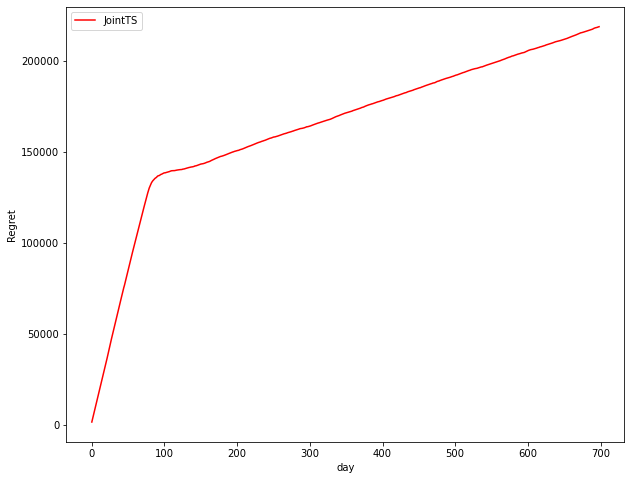

In [21]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
#opt = (margins_rep[opt_arm] * conv_rates_rep[opt_arm] * (1 + tau_rep[opt_arm]) - costs_per_click_tile[opt_arm]) * np.rint(n_clicks_tile[opt_arm]).astype(int)
plt.plot(np.cumsum(np.mean(opt - rewards_per_experiment, axis=0)), 'r')
#plt.plot(3935*(np.sqrt(np.linspace(0,364,364))))
#for val in rewards_per_experiment.values():
#    plt.plot(np.cumsum(np.mean(opt - val, axis=0)))
plt.legend(['JointTS', 'sqrt(t)'])
plt.show()

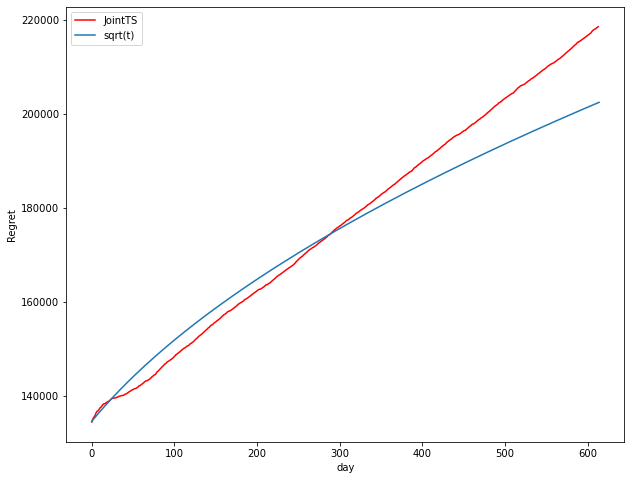

In [22]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
#opt = (margins_rep[opt_arm] * conv_rates_rep[opt_arm] * (1 + tau_rep[opt_arm]) - costs_per_click_tile[opt_arm]) * np.rint(n_clicks_tile[opt_arm]).astype(int)
plt.plot(np.cumsum(np.mean(opt - rewards_per_experiment, axis=0))[85:], 'r')
plt.plot(3935*(np.sqrt(np.linspace(85,700,700-85))+25))
#for val in rewards_per_experiment.values():
#    plt.plot(np.cumsum(np.mean(opt - val, axis=0)))
plt.legend(['JointTS', 'sqrt(t)'])
plt.show()

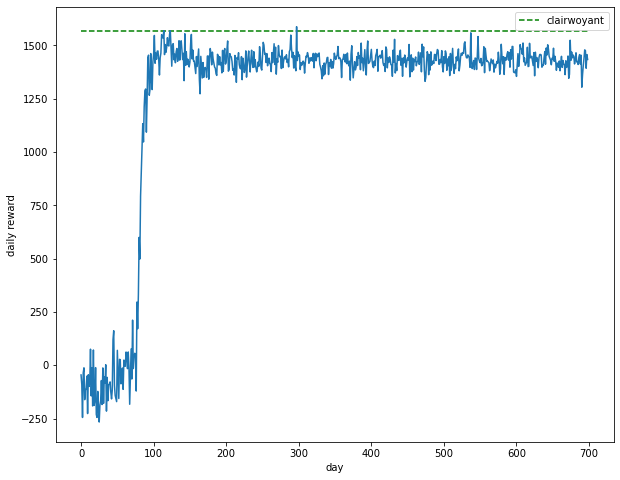

In [23]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([opt]*700, '--g', label='clairwoyant')
plt.plot(np.mean(rewards_per_experiment, axis=0))
plt.legend(loc='best')
plt.show()